In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

import captum

In [2]:
class Model(nn.Module):
    def __init__(self):
        ###INPUT MODULES###
        # mobile net takes images of size (224x224x3) as input

        super(Model, self).__init__()
        self.mobile_net = models.mobilenet_v2(num_classes=512)
        self.image_module = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),

        )
        self.imu_module = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
        )

        self.depth_module = nn.Sequential(  # input of size: 200x88)
            nn.Conv2d(1, 32, 4, 2, 1, bias=True),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1, bias=True),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=True),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1, bias=True),
            nn.Dropout(p=0.2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Flatten(),

            nn.Linear(3072, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(True),

            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(True)
        )

        # print("SUMMARY DEPTH MODULE")
        # print(summary(self.depth_module,(1,88,200)))
        self.speed_module = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True)
        )

        self.dense_layers = nn.Sequential(
            # 512depth, 512image, 128speed, 256imu
            nn.Linear(1408, 512),
            nn.ReLU(True)
        )

        ###COMMAND BRANCHEs###
        self.straight_net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )

        self.right_net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )
        self.left_net = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            print("Block:", block)
            if block == 'mobile_net':
                pass
            else:
                for m in self._modules[block]:
                    if isinstance(m, nn.Conv2d):
                        # nn.init.normal(m.weight, mean=0, std=0.01)
                        nn.init.xavier_uniform(m.weight)
                    elif isinstance(m, nn.Linear):
                        # nn.init.normal(m.weight, mean=0, std=0.01)
                        nn.init.xavier_uniform(m.weight)
                    else:
                        pass

    def forward(self, image, depth, imu, speed, command):
#         image = input_data[0]
        image = self._image_module(image)
#         imu = input_data[2]
        imu = self._imu_module(imu)
        depth = depth[:, None, :, :]
        depth = self._depth_module(depth)
#         speed = input_data[3]
        speed = self._speed_module(speed)
#         command = input_data[4]

        concat = torch.cat((image, imu, depth, speed), 1)
        concat = self._dense_layers(concat)

        output = torch.Tensor()
        batch_size =len(image)
        for i in range(batch_size):
            if command[i] == 1:
                if output.shape == torch.Size([0]):
                    output = self._straight_net(concat)
                else:
                    torch.stack(tensors=(output, self._straight_net(concat)), dim=1)

            elif command[i] == 2:
                if output.shape == torch.Size([0]):
                    output = self._right_net(concat)
                else:
                    torch.stack(tensors=(output, self._right_net(concat)), dim=1)

            elif command[i] == 0:
                if output.shape == torch.Size([0]):
                    output = self._left_net(concat)
                else:
                    torch.stack(tensors=(output, self._left_net(concat)), dim=1)

        return output

    def _image_module(self, x):
        x = self.mobile_net(x)
        return self.image_module(x)

    def _imu_module(self, x):
        return self.imu_module(x)

    def _depth_module(self, x):
        return self.depth_module(x)

    def _speed_module(self, x):
        return self.speed_module(x)

    def _dense_layers(self, x):
        return self.dense_layers(x)

    def _straight_net(self, x):
        return self.straight_net(x)

    def _right_net(self, x):
        return self.right_net(x)

    def _left_net(self, x):
        return self.left_net(x)

In [3]:
import h5py
import numpy as np

In [4]:
input_data = h5py.File('./test_data2/12_dataset6_data_1200.h5')

In [5]:
input_data

<HDF5 file "12_dataset6_data_1200.h5" (mode r)>

In [6]:
rgb = np.array(input_data['rgb_front/image'])

In [7]:
import matplotlib.pyplot as plt

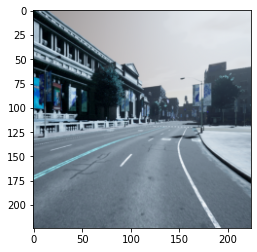

In [8]:
plt.imshow(rgb)

In [9]:
depth = np.array(input_data['depth_front/image'])

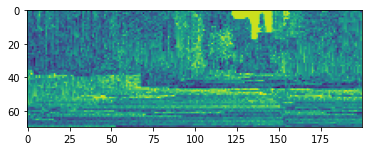

In [10]:
plt.imshow(depth)

In [11]:
from imgaug import augmenters as iaa
from helper import RandomTransWrapper, normalize_imu, normalize_speed, normalize_steering, normalize_image, noisy

In [12]:
depth = normalize_image(depth)

In [13]:
others = np.array(input_data['others']).astype(np.float32)

imu = normalize_imu(others[:10])

speed = normalize_speed(others[10])

command = others[11]

In [14]:
depth[None,:,:].shape

(1, 70, 200)

In [15]:
label = [others[12],  others[14], normalize_steering(others[13])]

# rgb = torch.Tensor(rgb)
# torch.permute(rgb, )

cuda1 = torch.device('cuda:1')

data    = [
    torch.Tensor(rgb[None,:,:,:]).permute((0,3,1,2)).to(cuda1),
    torch.Tensor(depth[None,:,:]).to(cuda1),
    torch.Tensor(np.array(imu)).to(cuda1),
    torch.Tensor(np.array([speed])).to(cuda1),
    torch.Tensor(np.array([command])).to(cuda1)
           ]


In [44]:
model = torch.load('./models/model_newdataset_oversample_1e-3.pt')
model.to(cuda1)
# model = Model()

Model(
  (mobile_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1

In [17]:
from dataloader import Train 

In [18]:
data_train = Train(data_dir='./test_data2/', train_eval_flag="test")
data, label = data_train.__getitem__(0)

In [19]:
label

[1.0, 0.0, 0.5]

In [20]:
baseline = []

In [21]:
for j in range(len(data)):
    data[j] = torch.Tensor(data[j][None,:]).to(cuda1)
    baseline.append(torch.zeros_like(data[j]))

In [22]:
output = model(*data)

In [23]:
output

tensor([[9.6786e-01, 4.3415e-04, 4.9376e-01]], device='cuda:1',
       grad_fn=<SigmoidBackward0>)

In [39]:
from captum.attr import IntegratedGradients, LayerIntegratedGradients, LRP, Saliency

In [67]:
ig =  LayerIntegratedGradients(model, model.depth_module[0])

In [68]:
a = ig.attribute((data[0], data[1], data[2], data[3], data[4]), target=0)

In [69]:
a.shape

torch.Size([1, 32, 35, 100])

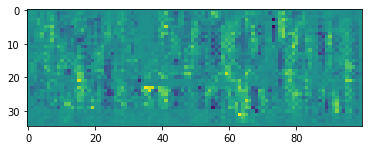

In [75]:
plt.imshow(a[0,2].cpu().numpy())

In [78]:
model.depth_module

Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): Dropout(p=0.2, inplace=False)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Dropout(p=0.2, inplace=False)
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (9): Dropout(p=0.2, inplace=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (13): Dropout(p=0.2, inplace=False)
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU(inplace=True)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=3072, out_features=512,